# 03 Network Architectures 

In this notebook, we investigate how we can work with more complicated network architectures than the simple MLP's.

The example will be a Logistic-Hazard which use the encoded (latent) variables of an autoencoder as covariates.
This means the network will have two heads, one for the autoencoder and the other for the Logistic-Hazard.

To approach this task we can use the `LogisticHazard`, but we need to define the network structure that combines the survival net with an autoencoder.
Also, we need to define a loss function that combines the loss of the `LogisticHazard` with that of the autoencoder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
from torch import nn
import torch.nn.functional as F
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

In [2]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [4]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [5]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

We like using the `sklearn_pandas.DataFrameMapper` to make feature mappers.

In [6]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The `LogisticHazard` is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

Note that we have two sets of targets.
The first, `y_train_surv`, is for the survival and contains the labels `(idx_durations, events)`.
The second is for the autoencoder (which is just the input covariates `x_train`).
This is important to note, as it will define the call arguments of our loss function.

In [8]:
num_durations = 10
labtrans = LogisticHazard.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train_surv = labtrans.fit_transform(*get_target(df_train))
y_val_surv = labtrans.transform(*get_target(df_val))

train = tt.tuplefy(x_train, (y_train_surv, x_train))
val = tt.tuplefy(x_val, (y_val_surv, x_val))

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [9]:
y_train_surv

(array([2, 3, 6, ..., 1, 5, 3]),
 array([0., 1., 0., ..., 1., 0., 0.], dtype=float32))

We see that we have combined `idx_durations` and `events` intro the tuple `y_train_surv`.

## The Neural Net

We first define our network `NetAESurv` with contains the encoder, decoder, and the survival part. 
We also include a `predict` method that saves computations by not computing the decoder.

In [10]:
class NetAESurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, encoded_features),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_features, 16), nn.ReLU(),
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, in_features),
        )
        self.surv_net = nn.Sequential(
            nn.Linear(encoded_features, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, out_features),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        phi = self.surv_net(encoded)
        return phi, decoded

    def predict(self, input):
        # Will be used by model.predict later.
        # As this only has the survival output, 
        # we don't have to change LogisticHazard.
        encoded = self.encoder(input)
        return self.surv_net(encoded)

All methods in `pycox` are built on `torchtuples.Model`.
The way `torchtuples` is made, a call to `model.predict` will use `model.net.predict` if it is defined, and use `model.net.forward` if `predict` is not defined.
As all the survival predictions in `pycox` are based on the `model.predict` method, a call to `model.predict_surv` will use the `NetAESurv.predict` method instead of the `NetAESurv.forward` method.
This way, the `model.predict_surv` methods will work as before!

In [11]:
in_features = x_train.shape[1]
encoded_features = 4
out_features = labtrans.out_features
net = NetAESurv(in_features, encoded_features, out_features)

## The Loss

We need to define a loss that combines the `LogisticHazard` loss with the loss of an autoencoder `MLELoss`.
The `forward` method defines how the loss is called, and need to be defined in accordance with how the data is structured.

The first arguments need to be the output of the net (`phi` and `decoded` above), and the remainder of the arguments need to have the same structure as the tuple structure of the targets in your data set, that is `train[1]`.

In [12]:
train[1].levels

((1, 1), 0)

We have structured our data such that `train[1] = (target_loghaz, target_ae)`, where `target_loghaz = (idx_durations, events)` and `target_ae` is just the input covariates.
So we need a loss with the call signature  `loss(phi, decoded, target_loghaz, target_ae)`.
We, therefore, create the following loss function (note that it is created in the same manner as a torch network)

In [13]:
class LossAELogHaz(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), 'Need `alpha` in [0, 1].'
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()
        
    def forward(self, phi, decoded, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        loss_surv = self.loss_surv(phi, idx_durations, events)
        loss_ae = self.loss_ae(decoded, target_ae)
        return self.alpha * loss_surv + (1 - self.alpha) * loss_ae

In [14]:
loss = LossAELogHaz(0.6)

## The model

We can now use the `LogisticHazard` model with the `net` and the `loss`.

In [15]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss=loss)

### Testing that it works

We can not test that everything works as expected by considering a single batch of data. This can be done by using the `make_dataloader` method.

In [16]:
dl = model.make_dataloader(train, batch_size=5, shuffle=False)
batch = next(iter(dl))

In [17]:
batch.shapes()

(torch.Size([5, 9]), ((torch.Size([5]), torch.Size([5])), torch.Size([5, 9])))

In [18]:
batch.levels

(0, ((2, 2), 1))

The `compute_metrics` method is the "brain" of the `model` as it is responsible for computing the output of the network and calculating the loss.
Here we also see the logic of how the loss function is called as we unpack the tuples `metric(*out, *target)`.
To test that it works, we can call it with the batch

In [19]:
??model.compute_metrics

Signature: model.compute_metrics(data, metrics=None) -> Dict[str, torch.Tensor]
Source:   
    def compute_metrics(self, data, metrics=None) -> Dict[str, torch.Tensor]:
        """Function for computing the loss and other metrics.
        
        Arguments:
            data {tensor or tuple} -- A batch of data. Typically the tuple `(input, target)`.

        Keyword Arguments:
            metrics {dict} -- A dictionary with metrics. If `None` use `self.metrics`. (default: {None})
        """
        if metrics is None:
            metrics = self.metrics
        if (self.loss is None) and (self.loss in metrics.values()):
            raise RuntimeError(f"Need to set `self.loss`.")

        input, target = data
        input = self._to_device(input)
        target = self._to_device(target)
        out = self.net(*input)
        out = tuplefy(out)
        return {name: metric(*out, *target) for name, metric in metrics.items()}
File:      ~/packages/torchtuples/torchtuples/base.py
Type:   

In [20]:
model.compute_metrics(batch)

{'loss': tensor(2.1274, grad_fn=<AddBackward0>)}

Alternatively, we can call the `score_in_batches` which computes the loss over the full data set. For larger data sets, this can be slow.

In [21]:
model.score_in_batches(*train)

{'loss': 2.1353516578674316}

## Training

For better monitoring, we add some metrics that corresponds to the `LogisticHazard` loss and the `MSELoss`, but have the same call structure as `LossAELogHaz`.

In [22]:
metrics = dict(
    loss_surv = LossAELogHaz(1),
    loss_ae   = LossAELogHaz(0)
)
callbacks = [tt.cb.EarlyStopping()]

We can now fit the model and plot the losses

In [23]:
batch_size = 256
epochs = 100
log = model.fit(*train, batch_size, epochs, callbacks, False, val_data=val, metrics=metrics)

In [24]:
res = model.log.to_pandas()

In [25]:
res.head()

,train_loss,train_loss_surv,train_loss_ae,val_loss,val_loss_surv,val_loss_ae
0,2.012700,2.860405,0.741140,1.818385,2.615916,0.622087
1,1.676086,2.354524,0.658429,1.358614,1.878866,0.578235
2,1.307018,1.764166,0.621296,1.151025,1.565904,0.528707
3,1.195468,1.619311,0.559702,1.038817,1.416264,0.472648
4,1.118429,1.528873,0.502764,1.049998,1.459745,0.435376


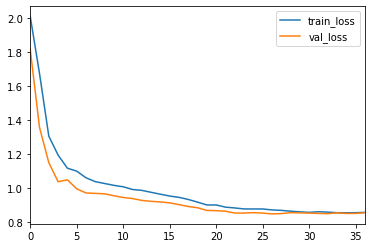

In [26]:
_ = res[['train_loss', 'val_loss']].plot()

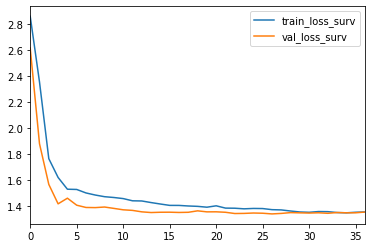

In [27]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

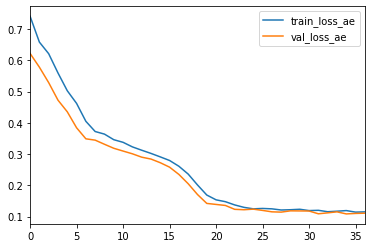

In [28]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

## Prediction

For prediction, remember that `model.predict` use the `net.predict` method, and because we defined it as only the survival part, the `predict_surv_df` behave as before.

In [29]:
surv = model.interpolate(10).predict_surv_df(x_test)

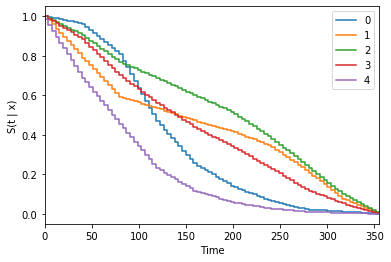

In [30]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

Under you can see that the `model.predict` method gives an array out, as the `model.net.predict` only gives an array (or tensor). 

If we want predictions from the `net.forward` method, we can use `model.predict_net` instead.

In [31]:
model.predict(x_test[:2])

array([[-13.314146  ,  -3.232014  ,  -1.6640139 ,  -0.32413414,
         -0.17921695,  -0.24341404,   0.09743847,   0.6742561 ,
         -0.08086838,   9.740675  ],
       [-12.070942  ,  -1.3327147 ,  -1.0963962 ,  -2.2161934 ,
         -2.0299942 ,  -2.0760274 ,  -1.5875834 ,  -0.576796  ,
          0.6470416 ,   8.179644  ]], dtype=float32)

In [32]:
model.predict_net(x_test[:2])

(array([[-13.314146  ,  -3.232014  ,  -1.6640139 ,  -0.32413414,
          -0.17921695,  -0.24341404,   0.09743847,   0.6742561 ,
          -0.08086838,   9.740675  ],
        [-12.070942  ,  -1.3327147 ,  -1.0963962 ,  -2.2161934 ,
          -2.0299942 ,  -2.0760274 ,  -1.5875834 ,  -0.576796  ,
           0.6470416 ,   8.179644  ]], dtype=float32),
 array([[-0.87191707,  1.8376998 ,  0.52234185,  1.4613888 ,  0.8503939 ,
          0.93256044,  0.82951564,  0.15673046,  1.0731695 ],
        [ 0.05569835, -0.8430163 ,  2.3545551 ,  0.93773973, -1.2269706 ,
          0.38499445,  0.79142815,  0.6561861 ,  0.33640665]],
       dtype=float32))

We can also pass a function to the `predict` methods, so we can only get the survival part from `predict_net`.

In [33]:
model.predict_net(x_test[:2], func=lambda x: x[0])

array([[-13.314146  ,  -3.232014  ,  -1.6640139 ,  -0.32413414,
         -0.17921695,  -0.24341404,   0.09743847,   0.6742561 ,
         -0.08086838,   9.740675  ],
       [-12.070942  ,  -1.3327147 ,  -1.0963962 ,  -2.2161934 ,
         -2.0299942 ,  -2.0760274 ,  -1.5875834 ,  -0.576796  ,
          0.6470416 ,   8.179644  ]], dtype=float32)

## Evaluation (as before)

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [34]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [35]:
ev.concordance_td('antolini')

0.6662427402602908

#### Brier Score

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times.
Here we just use 100 time-points between the min and max duration in the test set.
Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

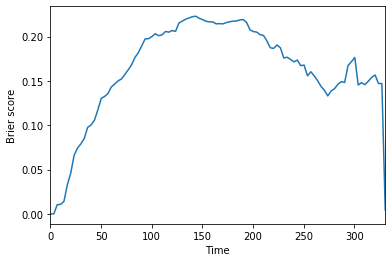

In [36]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

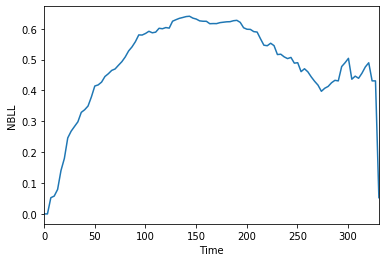

In [37]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [38]:
ev.integrated_brier_score(time_grid) 

0.16289642991716796

In [39]:
ev.integrated_nbll(time_grid) 

0.4834288744418562

# Next

You can now look at other examples of survival methods in the [examples folder](https://nbviewer.jupyter.org/github/havakv/pycox/tree/master/examples).
Or, alternatively take a look at

- the more advanced training procedures in the notebook [02_introduction.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/02_introduction.ipynb).
- working with DataLoaders and convolutional networks in the notebook [04_mnist_dataloaders_cnn.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/04_mnist_dataloaders_cnn.ipynb).